In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
from utils.pc_viz import show_pointclouds
from architecture import CustomDenseDeepGCN

import vtk
from numpy import random
from gcn_lib.dense.torch_edge import DenseKnnGraph

import matplotlib.pyplot as plt

from modelnet40 import ModelNet40
from architecture import ClassificationGraphNN
from types import SimpleNamespace
import networkx as nx
from tqdm import tqdm

from tqdm import tqdm
from gcn_lib.dense import pairwise_distance

def project_2d_based_on_keypoints(pc,keypoints):
    #First vector of our basis will be red-to-red
    v0 = pc[keypoints[2]] - pc[keypoints[1]]
    v0 = v0/torch.norm(v0)

    #Second vector will be perpendicular to this one and pertaining to the plane
    #We solve system of equations for alpha and x:
    #<p0-x, v0>=0 (vectors should be normal)
    #x = p1 + alpha*v1 (x should be aligned with the line defined by p1 and v1)
    alpha = torch.dot(v0, pc[keypoints[0]]-pc[keypoints[1]])
    x = pc[keypoints[1]] + alpha*v0
    v1 = pc[keypoints[0]]-x
    v1 = v1/torch.norm(v1)

    trans = torch.cat((v0.unsqueeze(1),v1.unsqueeze(1)), dim=1)
    print(pc.shape, trans.shape)

    proj = torch.matmul(pc,trans).detach()
    return proj

class VtkPointCloud:

    def __init__(self, zMin=-10.0, zMax=10.0, maxNumPoints=1e6):
        self.maxNumPoints = maxNumPoints
        self.vtkPolyData = vtk.vtkPolyData()

        self.colors = vtk.vtkUnsignedCharArray()
        self.colors.SetNumberOfComponents(3)
        self.colors.SetName("Colors")

        self.clearPoints()
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputData(self.vtkPolyData)
        mapper.SetColorModeToDefault()
        mapper.SetScalarRange(zMin, zMax)
        mapper.SetScalarVisibility(1)
        self.vtkActor = vtk.vtkActor()
        self.vtkActor.SetMapper(mapper)

    def addPoint(self, point, color, important = False):
        if self.vtkPoints.GetNumberOfPoints() < self.maxNumPoints:
            pointId = self.vtkPoints.InsertNextPoint(point[:])
            self.colors.InsertNextTuple(color)
            self.vtkDepth.InsertNextValue(point[2])
            self.vtkCells.InsertNextCell(1)
            self.vtkCells.InsertCellPoint(pointId)
            if important:
                self.vtkActor.GetProperty().SetPointSize(4)
            else:
                self.vtkActor.GetProperty().SetPointSize(8)
        else:
            r = random.randint(0, self.maxNumPoints)
            self.vtkPoints.SetPoint(r, point[:])
        self.vtkPolyData.GetPointData().SetScalars(self.colors)
        self.vtkCells.Modified()
        self.vtkPoints.Modified()
        self.vtkDepth.Modified()

    def addLine(self, id1, id2):
        self.vtkLines.InsertNextCell(2, [id1, id2])

    def clearPoints(self):
        self.vtkPoints = vtk.vtkPoints()
        self.vtkCells = vtk.vtkCellArray()
        self.vtkLines = vtk.vtkCellArray()
        self.vtkDepth = vtk.vtkDoubleArray()
        self.vtkDepth.SetName('DepthArray')
        self.vtkPolyData.SetPoints(self.vtkPoints)
        self.vtkPolyData.SetVerts(self.vtkCells)
        self.vtkPolyData.SetLines(self.vtkLines)
        self.vtkPolyData.GetPointData().SetScalars(self.vtkDepth)
        self.vtkPolyData.GetPointData().SetActiveScalars('DepthArray')

def dense_knn_to_set(knn_index):
    edges = set()
    for i in range(knn_index.shape[2]):
        for j in range(knn_index.shape[3]):
            l = list(knn_index[:,:,i,j])
            tuple = (int(l[0]),int(l[1]))
            edges.add(tuple)
    return edges

def scaled_stress(feats1,feats2):
    f1 = feats1.transpose(2, 1).squeeze(-1)
    f2 = feats2.transpose(2, 1).squeeze(-1)
    d1squared = pairwise_distance(f1)
    d2squared = pairwise_distance(f2) 
    #d1 = torch.sqrt(d1squared/f1.shape[2] + 1)
    #d2 = torch.sqrt(d2squared/f2.shape[2] + 1)
    d1 = torch.sqrt(d1squared)
    d2 = torch.sqrt(d2squared)
    #remove nans
    d1[d1!=d1]=0
    d2[d2!=d2]=0
    #print(d1[0,0,0])
    crit = torch.nn.MSELoss(reduction='none')
    #print(d1.shape, ((d1squared.view(f1.shape[0],-1)).sum(1, keepdim=True).unsqueeze(-1)).shape)
    #Shapes are B,N,N and B,1,1
    scaled_se = 2*crit(d1,d2)/((d1squared.view(f1.shape[0],-1)).sum(1, keepdim=True).unsqueeze(-1))
    #print(scaled_se.shape)
    flat_scaled_se = scaled_se.view(f1.shape[0],-1)
    #print(flat_scaled_se.shape)
    return torch.sqrt(flat_scaled_se.sum(dim=1).sum(dim=0)/2)

Using vtk version 9.1.0


# S3DIS

In [3]:
filename = "data/ply_data_all_0.h5"
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = torch.Tensor(f[a_group_key])

Keys: <KeysViewHDF5 ['data', 'label']>


In [ ]:
checkpointdense = torch.load('weights/mlpdense_best.pth',map_location='cpu')
checkpoint3 = torch.load('weights/mlp3_best.pth',map_location='cpu')

mlp_1layer = torch.nn.Linear(9,9)
mlp_1layer.weight.data = checkpoint3['state_dict']['module.graph_mlp.0.weight']
mlp_1layer.bias.data = checkpoint3['state_dict']['module.graph_mlp.0.bias']

mlpdense = torch.nn.Sequential(torch.nn.Linear(9,32),
                          torch.nn.ReLU(),
                          torch.nn.Linear(32,9))
mlpdense[0].weight.data = checkpointdense['state_dict']['module.graph_mlp.0.weight']
mlpdense[0].bias.data = checkpointdense['state_dict']['module.graph_mlp.0.bias']
mlpdense[2].weight.data = checkpointdense['state_dict']['module.graph_mlp.2.weight']
mlpdense[2].bias.data = checkpointdense['state_dict']['module.graph_mlp.2.bias']

knn = DenseKnnGraph(16)

pointCloud = VtkPointCloud()

#Add points
for j in range(data.shape[1]):
    pointCloud.addPoint(list(data[1,j,0:3]),list(255*data[1,j,3:6]))
#Add graph lines
#(batch_size, num_dims, num_points, 1)
knn_index = knn(data[1,:,:3].unsqueeze(0).unsqueeze(-1).transpose(2,1))
knn_index_mlpdense = knn(mlpdense(data[1,:,:]).unsqueeze(0).unsqueeze(-1).transpose(2,1))
knn_index_mlp_1layer = knn(mlp_1layer(data[1,:,:]).unsqueeze(0).unsqueeze(-1).transpose(2,1))
edges = dense_knn_to_set(knn_index)
edges_mlpdense = dense_knn_to_set(knn_index_mlpdense)
edges_mlp_1layer = dense_knn_to_set(knn_index_mlp_1layer)
diff_knn_dense = edges.difference(edges_mlpdense)
diff_dense_knn = edges_mlpdense.difference(edges)
diff_1layer_dense = edges_mlp_1layer.difference(edges_mlp_1layer)
diff_1layer_knn = edges.difference(edges_mlp_1layer)

for edge in diff_1layer_knn:
    pointCloud.addLine(edge[0],edge[1])

# Renderer
renderer = vtk.vtkRenderer()
renderer.AddActor(pointCloud.vtkActor)
renderer.SetBackground(.2, .3, .4)
renderer.ResetCamera()

# Render Window
renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

# Interactor
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)

# Begin Interaction
renderWindow.Render()
renderWindowInteractor.Start()

In [8]:
def length(A,B):
    return float(np.sqrt(sum((A-B)**2)))

def sin_angle(A,B):
    #sin of angle between line and XY plane
    return float(abs(torch.dot(A-B,torch.Tensor([0,0,1])))/(np.sqrt(torch.dot(A-B,A-B))*np.sqrt(torch.dot(torch.Tensor([0,0,1]),torch.Tensor([0,0,1])))))

def linestats(edges,data):
    df = {'A':[], 'B': [],'xA':[], 'xB':[],'yA':[], 'yB':[],'zA':[], 'zB':[],'rA':[], 'rB':[],'gA':[], 'gB':[],'bA':[], 'bB':[], 'sin_angle':[], 'dist':[],'dist2':[], 'color_diff':[]}
    for edge in edges:
        df['A'].append(edge[0])
        df['B'].append(edge[1])
        df['xA'].append(float(data[1,edge[0],0]))
        df['xB'].append(float(data[1,edge[1],0]))
        df['yA'].append(float(data[1,edge[0],1]))
        df['yB'].append(float(data[1,edge[1],1]))
        df['zA'].append(float(data[1,edge[0],2]))
        df['zB'].append(float(data[1,edge[1],2]))
        df['rA'].append(float(data[1,edge[0],3]))
        df['rB'].append(float(data[1,edge[1],3]))
        df['gA'].append(float(data[1,edge[0],4]))
        df['gB'].append(float(data[1,edge[1],4]))
        df['bA'].append(float(data[1,edge[0],5]))
        df['bB'].append(float(data[1,edge[1],5]))
        df['dist'].append(length(data[1,edge[0],:3],data[1,edge[1],:3]))
        df['dist2'].append(length(data[1,edge[0],6:9],data[1,edge[1],6:9]))
        df['sin_angle'].append(sin_angle(data[1,edge[0],:3],data[1,edge[1],:3]))
        df['color_diff'].append(length(data[1,edge[0],3:6],data[1,edge[1],3:6]))
    return pd.DataFrame.from_dict(df, orient='columns')

In [9]:
linestats_knn = linestats(edges,data)
linestats_dense = linestats(edges_mlpdense,data)
linestats_1layer = linestats(edges_mlp_1layer,data)

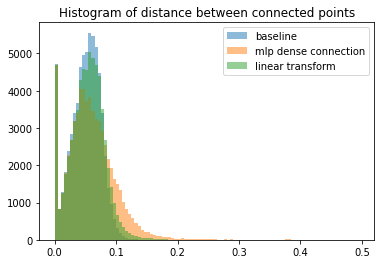

Mean distance baseline: 0.04973599142430629
Mean distance linear transform: 0.05277491684033109
Mean distance mlp dense connection: 0.06030843124227303


In [171]:
import matplotlib.pyplot as plt
bins = np.arange(0,0.5,0.005)
plt.hist(linestats_knn['dist'],bins = bins,label='baseline',alpha = 0.5)
plt.hist(linestats_dense['dist'],bins = bins,label = 'mlp dense connection',alpha = 0.5)
plt.hist(linestats_1layer['dist'],bins = bins,label = 'linear transform',alpha = 0.5)
plt.title('Histogram of distance between connected points')
plt.legend(loc='upper right')
plt.show()
print('Mean distance baseline:',np.mean(linestats_knn['dist']))
print('Mean distance linear transform:',np.mean(linestats_1layer['dist']))
print('Mean distance mlp dense connection:',np.mean(linestats_dense['dist']))

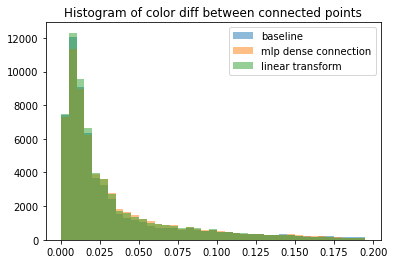

Mean color diff baseline: 0.05997744332095323
Mean color diff linear transform: 0.03760809095497564
Mean color diff mlp dense connection: 0.045970333221845294


In [172]:
bins = np.arange(0,0.2,0.005)
plt.hist(linestats_knn['color_diff'],bins = bins,label='baseline',alpha = 0.5)
plt.hist(linestats_dense['color_diff'],bins = bins,label = 'mlp dense connection',alpha = 0.5)
plt.hist(linestats_1layer['color_diff'],bins = bins,label = 'linear transform',alpha = 0.5)
plt.title('Histogram of color diff between connected points')
plt.legend(loc='upper right')
plt.show()
print('Mean color diff baseline:',np.mean(linestats_knn['color_diff']))
print('Mean color diff linear transform:',np.mean(linestats_1layer['color_diff']))
print('Mean color diff mlp dense connection:',np.mean(linestats_dense['color_diff']))

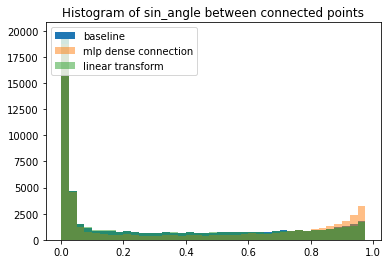

Mean sin_angle baseline: 0.365943415892469
Mean sin_angle linear transform: 0.35456264132900567
Mean sin_angle mlp dense connection: 0.44843574843409767


In [174]:
bins = np.arange(0,1,0.025)
plt.hist(linestats_knn['sin_angle'],bins = bins,label='baseline',alpha = 1)
plt.hist(linestats_dense['sin_angle'],bins = bins,label = 'mlp dense connection',alpha = 0.5)
plt.hist(linestats_1layer['sin_angle'],bins = bins,label = 'linear transform',alpha = 0.5)
plt.title('Histogram of sin_angle between connected points')
plt.legend(loc='upper left')
plt.show()
print('Mean sin_angle baseline:',np.mean(linestats_knn['sin_angle']))
print('Mean sin_angle linear transform:',np.mean(linestats_1layer['sin_angle']))
print('Mean sin_angle mlp dense connection:',np.mean(linestats_dense['sin_angle']))

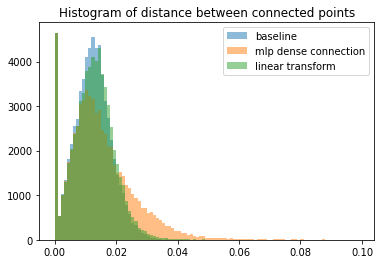

Mean distance baseline: 0.011986056734185624
Mean distance linear transform: 0.012518345059476577
Mean distance mlp dense connection: 0.015206640804877214


In [175]:
bins = np.arange(0,0.1,0.001)
plt.hist(linestats_knn['dist2'],bins = bins,label='baseline',alpha = 0.5)
plt.hist(linestats_dense['dist2'],bins = bins,label = 'mlp dense connection',alpha = 0.5)
plt.hist(linestats_1layer['dist2'],bins = bins,label = 'linear transform',alpha = 0.5)
plt.title('Histogram of distance between connected points')
plt.legend(loc='upper right')
plt.show()
print('Mean distance baseline:',np.mean(linestats_knn['dist2']))
print('Mean distance linear transform:',np.mean(linestats_1layer['dist2']))
print('Mean distance mlp dense connection:',np.mean(linestats_dense['dist2']))

# ModelNet40

In [2]:
opt = SimpleNamespace(n_filters = 64, 
                      k= 16,
                      act='relu',
                      norm = 'batch',
                      bias = True,
                      dropout = 0.3,
                      n_blocks = 4,
                      graph = 'KNN',
                      knn_criterion = 'MLP',
                      graph_feats = 2,
                      in_channels = 3,
                      graph_dropout = 0,
                      n_classes = 40)

model = ClassificationGraphNN(opt)
state_dict = torch.load('weights/MLP_3_16_2_best.pth', map_location='cpu')
print(state_dict.keys())
model.load_state_dict(state_dict['state_dict'])
model.eval()


#Load data
dataset = ModelNet40(1024,'test')
#i=29 car = 7, Figure from Paper: guitar(29)
i=22
while dataset[i][1]!=17:
    i+=1
print(i)
pc, target = dataset[i]
print(pc.shape)

#Forward pass:

pred, edge_features = model(torch.Tensor(pc).unsqueeze(0).unsqueeze(-1).transpose(2,1))

print(edge_features.shape)

dict_keys(['epoch', 'state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_value'])
29
(1024, 3)
torch.Size([1, 2, 1024, 1])


In [19]:
knn = DenseKnnGraph(16)

pointCloud = VtkPointCloud()

points = torch.Tensor(pc)
graph_feats = edge_features.squeeze(0).squeeze(-1).transpose(0,1)

#Add graph lines
#(batch_size, num_dims, num_points, 1)
knn_index = knn(edge_features)
#knn_index = knn(points.unsqueeze(0).unsqueeze(-1).transpose(2,1))
edges = dense_knn_to_set(knn_index)

important_point = 85

important_neighbors = []
for edge in edges:
    if edge[1] == important_point:
        important_neighbors.append(edge[0])

#Add points
for j in range(points.shape[0]):
    if j == important_point:
        color = [255,0,0]
    elif j in important_neighbors:
        color = [0,0,255]
    else:
        color = [0,0,0]
    pointCloud.addPoint(list(graph_feats[j])+[0,0],color)

for edge in edges:
    if edge[1] == important_point:
        pointCloud.addLine(edge[0],edge[1])

# Renderer
renderer = vtk.vtkRenderer()
renderer.AddActor(pointCloud.vtkActor)
renderer.SetBackground(255,255,255)
renderer.ResetCamera()

# Render Window
renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

# Interactor
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)

# Begin Interaction
renderWindow.Render()
renderWindowInteractor.Start()

## Graph metrics

In [23]:
pc, target = dataset[0]
print(pc.shape)
points = torch.Tensor(pc)

#Forward pass:

pred, edge_features = model(points.unsqueeze(0).unsqueeze(-1).transpose(2,1))

knn_index_mlp = knn(edge_features)
knn_index_xyz = knn(points.unsqueeze(0).unsqueeze(-1).transpose(2,1))
edges_mlp = dense_knn_to_set(knn_index_mlp)
edges_xyz = dense_knn_to_set(knn_index_xyz)

nodelist = list(range(points.shape[0]))

DG_mlp = nx.DiGraph()
DG_mlp.add_nodes_from(nodelist)
DG_mlp.add_edges_from(edges_mlp)

DG_xyz = nx.DiGraph()
DG_xyz.add_nodes_from(nodelist)
DG_xyz.add_edges_from(edges_xyz)

print('avg shortest path length (MLP):', nx.average_shortest_path_length(DG_mlp))
print('avg shortest path length (baseline):', nx.average_shortest_path_length(DG_xyz))
#print('Number of connected components (MLP):', nx.number_connected_components(DG_mlp))
#print('Number of connected components (basline):', nx.number_connected_components(DG_xyz))

(1024, 3)
avg shortest path length (MLP): 48.73673765120968
avg shortest path length (baseline): 7.897081004093353


In [21]:
dataset = ModelNet40(1024,'test')
asp_mlp = 0
asp_xyz = 0
count = 0
for i in tqdm(range(30)):
    pc, target = dataset[i]
    points = torch.Tensor(pc)

    #Forward pass:

    pred, edge_features = model(points.unsqueeze(0).unsqueeze(-1).transpose(2,1))

    knn_index_mlp = knn(edge_features)
    knn_index_xyz = knn(points.unsqueeze(0).unsqueeze(-1).transpose(2,1))
    edges_mlp = dense_knn_to_set(knn_index_mlp)
    edges_xyz = dense_knn_to_set(knn_index_xyz)

    nodelist = list(range(points.shape[0]))

    DG_mlp = nx.DiGraph()
    DG_mlp.add_nodes_from(nodelist)
    DG_mlp.add_edges_from(edges_mlp)

    DG_xyz = nx.DiGraph()
    DG_xyz.add_nodes_from(nodelist)
    DG_xyz.add_edges_from(edges_xyz)
    
    asp_mlp += nx.average_shortest_path_length(DG_mlp)
    asp_xyz += nx.average_shortest_path_length(DG_xyz)
    count += 1
    
print('avg shortest path length (MLP):', asp_mlp/count)
print('avg shortest path length (baseline):', asp_xyz/count)

100%|██████████| 30/30 [02:10<00:00,  4.35s/it]

avg shortest path length (MLP): 48.04912879424282
avg shortest path length (baseline): 8.506743245204056


In [38]:
model.eval()
dataset = ModelNet40(1024,'test')
total_stress = 0
count = 0
for pc, target in tqdm(dataset):
    with torch.no_grad():
        points = torch.Tensor(pc).unsqueeze(0).unsqueeze(-1).transpose(2,1)

        #Forward pass:
        pred, edge_features = model(points)

        pc_stress = scaled_stress(points,edge_features)

        if not count%50:
            print(count,pc_stress)

        total_stress += pc_stress

        count += 1
    
print('average scaled stress:', total_stress/count)

  0%|          | 1/2468 [00:00<14:25,  2.85it/s]

0 tensor(0.0225)


  2%|▏         | 51/2468 [00:16<12:42,  3.17it/s]

50 tensor(0.0230)


  4%|▍         | 101/2468 [00:32<12:27,  3.17it/s]

100 tensor(0.0197)


  6%|▌         | 151/2468 [00:48<12:27,  3.10it/s]

150 tensor(0.0262)


  8%|▊         | 201/2468 [01:06<18:33,  2.04it/s]

200 tensor(0.0195)


 10%|█         | 251/2468 [01:24<11:42,  3.16it/s]

250 tensor(0.0256)


 12%|█▏        | 301/2468 [01:40<11:28,  3.15it/s]

300 tensor(0.0215)


 14%|█▍        | 351/2468 [01:56<11:10,  3.16it/s]

350 tensor(0.0293)


 16%|█▌        | 401/2468 [02:12<11:17,  3.05it/s]

400 tensor(0.0254)


 18%|█▊        | 451/2468 [02:29<10:50,  3.10it/s]

450 tensor(0.0264)


 20%|██        | 501/2468 [02:45<10:24,  3.15it/s]

500 tensor(0.0223)


 22%|██▏       | 551/2468 [03:02<10:10,  3.14it/s]

550 tensor(0.0163)


 24%|██▍       | 601/2468 [03:17<09:48,  3.17it/s]

600 tensor(0.0214)


 26%|██▋       | 651/2468 [03:33<09:35,  3.16it/s]

650 tensor(0.0150)


 28%|██▊       | 701/2468 [03:49<09:17,  3.17it/s]

700 tensor(0.0208)


 30%|███       | 751/2468 [04:05<09:01,  3.17it/s]

750 tensor(0.0254)


 32%|███▏      | 801/2468 [04:22<10:59,  2.53it/s]

800 tensor(0.0246)


 34%|███▍      | 851/2468 [04:41<08:54,  3.02it/s]

850 tensor(0.0240)


 37%|███▋      | 901/2468 [04:58<09:04,  2.88it/s]

900 tensor(0.0207)


 39%|███▊      | 951/2468 [05:14<08:03,  3.14it/s]

950 tensor(0.0280)


 41%|████      | 1001/2468 [05:30<07:45,  3.15it/s]

1000 tensor(0.0211)


 43%|████▎     | 1051/2468 [05:46<07:40,  3.08it/s]

1050 tensor(0.0262)


 45%|████▍     | 1101/2468 [06:02<07:14,  3.15it/s]

1100 tensor(0.0226)


 47%|████▋     | 1151/2468 [06:19<07:27,  2.95it/s]

1150 tensor(0.0252)


 49%|████▊     | 1201/2468 [06:36<06:41,  3.15it/s]

1200 tensor(0.0226)


 51%|█████     | 1251/2468 [06:52<06:26,  3.15it/s]

1250 tensor(0.0232)


 53%|█████▎    | 1301/2468 [07:08<06:08,  3.16it/s]

1300 tensor(0.0259)


 55%|█████▍    | 1351/2468 [07:23<05:53,  3.16it/s]

1350 tensor(0.0286)


 57%|█████▋    | 1401/2468 [07:39<05:37,  3.16it/s]

1400 tensor(0.0307)


 59%|█████▉    | 1451/2468 [07:56<06:08,  2.76it/s]

1450 tensor(0.0192)


 61%|██████    | 1501/2468 [08:14<05:31,  2.92it/s]

1500 tensor(0.0264)


 63%|██████▎   | 1551/2468 [08:30<05:39,  2.70it/s]

1550 tensor(0.0290)


 65%|██████▍   | 1601/2468 [08:50<05:10,  2.79it/s]

1600 tensor(0.0166)


 67%|██████▋   | 1651/2468 [09:06<04:19,  3.15it/s]

1650 tensor(0.0208)


 69%|██████▉   | 1701/2468 [09:24<04:36,  2.77it/s]

1700 tensor(0.0269)


 71%|███████   | 1751/2468 [09:41<04:04,  2.93it/s]

1750 tensor(0.0231)


 73%|███████▎  | 1801/2468 [09:57<03:53,  2.85it/s]

1800 tensor(0.0231)


 75%|███████▌  | 1851/2468 [10:14<03:22,  3.05it/s]

1850 tensor(0.0274)


 77%|███████▋  | 1901/2468 [10:30<02:59,  3.16it/s]

1900 tensor(0.0258)


 79%|███████▉  | 1951/2468 [10:46<02:45,  3.12it/s]

1950 tensor(0.0242)


 81%|████████  | 2001/2468 [11:02<02:27,  3.16it/s]

2000 tensor(0.0266)


 83%|████████▎ | 2051/2468 [11:18<02:12,  3.16it/s]

2050 tensor(0.0206)


 85%|████████▌ | 2101/2468 [11:33<01:56,  3.16it/s]

2100 tensor(0.0266)


 87%|████████▋ | 2151/2468 [11:49<01:40,  3.15it/s]

2150 tensor(0.0257)


 89%|████████▉ | 2201/2468 [12:05<01:25,  3.14it/s]

2200 tensor(0.0245)


 91%|█████████ | 2251/2468 [12:21<01:09,  3.14it/s]

2250 tensor(0.0185)


 93%|█████████▎| 2301/2468 [12:37<00:54,  3.06it/s]

2300 tensor(0.0182)


 95%|█████████▌| 2351/2468 [12:53<00:37,  3.15it/s]

2350 tensor(0.0214)


 97%|█████████▋| 2401/2468 [13:10<00:21,  3.09it/s]

2400 tensor(0.0216)


 99%|█████████▉| 2451/2468 [13:27<00:05,  3.15it/s]

2450 tensor(0.0286)


100%|██████████| 2468/2468 [13:32<00:00,  3.04it/s]

average scaled stress: tensor(0.0233)


## learnt features plots of guitar (index 29)

### 2D plot

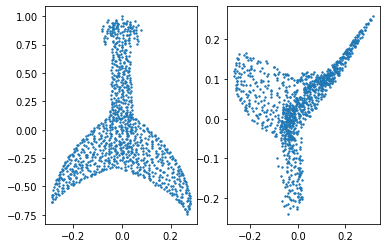

In [32]:
opt = SimpleNamespace(n_filters = 64, 
                      k= 16,
                      act='relu',
                      norm = 'batch',
                      bias = True,
                      dropout = 0.3,
                      n_blocks = 4,
                      graph = 'KNN',
                      knn_criterion = 'MLP',
                      graph_feats = 2,
                      in_channels = 3,
                      graph_dropout = 0,
                      n_classes = 40)

model = ClassificationGraphNN(opt)
state_dict = torch.load('weights/MLP_3_16_2_best.pth', map_location='cpu')
model.load_state_dict(state_dict['state_dict'])
model.eval()

dataset = ModelNet40(1024, 'test')
pc, target = dataset[29]

points = torch.Tensor(pc).unsqueeze(0).unsqueeze(-1).transpose(2,1)

pred, edge_features = model(points)

twod_feats = edge_features.squeeze(0).detach().numpy()
twod_proj = points.squeeze(0).detach().numpy()

fig, axs = plt.subplots(1,2)
axs[0].scatter(twod_proj[2],twod_proj[0], s = 2)
axs[1].scatter(twod_feats[0],twod_feats[1], s = 2)

### 3D proyected in 2D plots with different gammas

torch.Size([1024, 3]) torch.Size([3, 2])


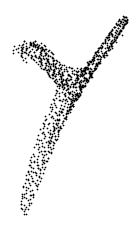

In [34]:
opt = SimpleNamespace(n_filters = 64, 
                      k= 16,
                      act='relu',
                      norm = 'batch',
                      bias = True,
                      dropout = 0.3,
                      n_blocks = 4,
                      graph = 'KNN',
                      knn_criterion = 'MLP',
                      graph_feats = 3,
                      in_channels = 3,
                      graph_dropout = 0,
                      n_classes = 40)

g = 0
fig = plt.figure()
ax = fig.add_subplot(111)
model = ClassificationGraphNN(opt)
if g == -1:
    state_dict = torch.load(f'weights/MLP_3_16_3_best.pth', map_location='cpu')
elif g == 0:
    state_dict = torch.load(f'weights/MLP_3_16_3_best.pth', map_location='cpu')
else:
    state_dict = torch.load(f'weights/MLP_3_16_3_scaled_stress{g}_best.pth', map_location='cpu')
model.load_state_dict(state_dict['state_dict'])
model.eval()

dataset = ModelNet40(1024, 'test')
pc, target = dataset[29]
pc = torch.Tensor(pc)

points = pc.unsqueeze(0).unsqueeze(-1).transpose(2,1)

plane_points = [torch.argmin(pc[:,2]).item(), torch.argmin(pc[:,0]).item(), torch.argmax(pc[:,0]).item()]
#plane_points = [1,35,754]

pred, edge_features = model(points)

if g == -1:
    feats = points.squeeze(0).detach().numpy()
    proj = feats
else:
    feats = edge_features.squeeze(0).squeeze(-1).transpose(0,1)
    proj = project_2d_based_on_keypoints(feats,plane_points)
ax.scatter(proj[:,1],proj[:,0], s =0.5, c = 'black')
ax.set_aspect('equal')
ax.axis('off')
fig.savefig('figures/guitarra.png', dpi=1024, pad_inches=0,bbox_inches='tight')

torch.Size([1024, 3])
(-0.28686004877090454, -0.28686004877090454, -0.28686004877090454)


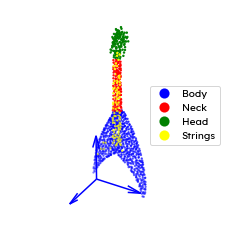

In [47]:
from matplotlib import font_manager

font_dirs = ['figures/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Lexend Deca'

opt = SimpleNamespace(n_filters = 64, 
                      k= 16,
                      act='relu',
                      norm = 'batch',
                      bias = True,
                      dropout = 0.3,
                      n_blocks = 4,
                      graph = 'KNN',
                      knn_criterion = 'MLP',
                      graph_feats = 3,
                      in_channels = 3,
                      graph_dropout = 0,
                      n_classes = 40)

g = 0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
model = ClassificationGraphNN(opt)
if g == -1:
    state_dict = torch.load(f'weights/MLP_3_16_3_best.pth', map_location='cpu')
elif g == 0:
    state_dict = torch.load(f'weights/MLP_3_16_3_best.pth', map_location='cpu')
else:
    state_dict = torch.load(f'weights/MLP_3_16_3_scaled_stress{g}_best.pth', map_location='cpu')
model.load_state_dict(state_dict['state_dict'])
model.eval()

dataset = ModelNet40(1024, 'test')

i=0
while dataset[i][1]!=24:
    i+=1
    
pc, target = dataset[29]
pc = torch.Tensor(pc)

points = pc.unsqueeze(0).unsqueeze(-1).transpose(2,1)

plane_points = [torch.argmin(pc[:,2]).item(), torch.argmin(pc[:,1]).item(), torch.argmax(pc[:,0]).item()]
#plane_points = [1,35,754]

pred, edge_features = model(points)

print(pc.shape)

colors = []

for i in range(1024):
    if pc[i,1] < 0.036:
        if pc[i,0] < 0.15:
            #colors.append('red')
            colors.append('blue')
        elif pc[i,0] < 0.7:
            #colors.append('peru')
            colors.append('red')
        else:
            #colors.append('saddlebrown')
            colors.append('green')
    else:
        #colors.append('black')
        colors.append('yellow')
    
#colors = ['black' for i in range(1024)]

ax.scatter(pc[:,2],-pc[:,1],pc[:,0], s = 2,c = colors)

dummy_lines = [plt.Line2D([],[], ls="", marker='.', 
                c = c, mew=.1, ms=20) for c in ['blue','red','green','yellow']]
ax.legend(dummy_lines, [lt for lt in ['Body','Neck','Head','Strings']], 
          loc='center right')
ax.set_box_aspect((np.ptp(pc[:,2]), np.ptp(pc[:,1]), np.ptp(pc[:,0]))) 

#start of arrows
sa = [torch.min(pc[:,2]),torch.max(pc[:,1]),torch.min(pc[:,0])]


sz = 0.5 
soa = np.array([[sa[0], sa[1], sa[2], sz, 0, 0], 
                [sa[0], sa[1], sa[2], 0, -sz, 0],
                [sa[0], sa[1], sa[2], 0, 0, sz]])

X, Y, Z, U, V, W = zip(*soa)
print(X)
ax.quiver(X, Y, Z, U, V, W, color = ['blue', 'blue', 'blue'])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.axis('off')
fig.savefig('figures/guitar3D_segmentation.png', dpi=1024, pad_inches=0,bbox_inches='tight')

torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024, 3]) torch.Size([3, 2])
torch.Size([1024

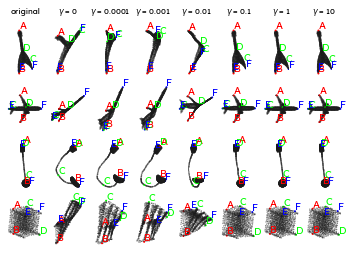

In [2]:
from matplotlib import font_manager

font_dirs = ['figures/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Lexend Deca'

opt = SimpleNamespace(n_filters = 64, 
                      k= 16,
                      act='relu',
                      norm = 'batch',
                      bias = True,
                      dropout = 0.3,
                      n_blocks = 4,
                      graph = 'KNN',
                      knn_criterion = 'MLP',
                      graph_feats = 3,
                      in_channels = 3,
                      graph_dropout = 0,
                      n_classes = 40)



gammas = [-1,0,0.0001,0.001,0.01,0.1,1,10]
dataset = ModelNet40(1024, 'test')
colors = [[1,0,0],[0,1,0],[0,0,1]]
samples = [29, 1, 230, 512]
fig, axs = plt.subplots(len(samples),len(gammas))

g = gammas[6]

for i,g in enumerate(gammas):
    
    model = ClassificationGraphNN(opt)
    if g == -1:
        state_dict = torch.load(f'weights/MLP_3_16_3_best.pth', map_location='cpu')
    elif g == 0:
        state_dict = torch.load(f'weights/MLP_3_16_3_best.pth', map_location='cpu')
    else:
        state_dict = torch.load(f'weights/MLP_3_16_3_scaled_stress{g}_best.pth', map_location='cpu')
    model.load_state_dict(state_dict['state_dict'])
    model.eval()
    
    for j in range(len(samples)):
    
        pc, target = dataset[samples[j]]
        pc = torch.Tensor(pc)

        important_points = {}
        for k in range(3):
            important_points[torch.argmax(pc[:,k]).item()] = k
            important_points[torch.argmin(pc[:,k]).item()] = k



        points = pc.unsqueeze(0).unsqueeze(-1).transpose(2,1)

        pred, edge_features = model(points)

        feats = edge_features.squeeze(0).squeeze(-1).transpose(0,1)

        plane_points = [torch.argmin(pc[:,2]).item(), torch.argmin(pc[:,0]).item(), torch.argmax(pc[:,0]).item()]

        if g == -1:
            proj = project_2d_based_on_keypoints(pc,plane_points)
        else:
            proj = project_2d_based_on_keypoints(feats,plane_points)

        col = [colors[important_points[i]] if i in important_points else [0.1,0.1,0.1] for i in range(pc.shape[0])]


        s = [1 if i in important_points else 0.05 for i in range(pc.shape[0])]
        #plt.axes().set_aspect('equal')
        axs[j,i].scatter(proj[:,1],proj[:,0], c = col, s = s)

        for p,letter in zip(important_points.keys(),['A','B','C','D','E','F']):
            axs[j,i].text(proj[p,1].item(), proj[p,0].item(), s = letter, c = colors[important_points[p]],
                        horizontalalignment='left', verticalalignment='bottom')
        #plt.scatter(pc[:,0],pc[:,2], c = col)
        axs[j,i].axes.set_aspect('equal')
        axs[j,i].axis('off')
        if j == 0:
            if g ==-1:
                axs[j,i].set_title('original', fontsize=8, pad = 15)
            else:
                axs[j,i].set_title(f'$\gamma$ = {g}', fontsize=8, pad = 15)

fig.savefig('figures/gamma_viz.png', dpi=1024, pad_inches=0,bbox_inches='tight')

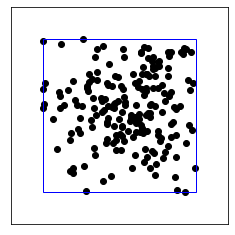

In [67]:
#Irregularity
fig = plt.figure()
ax = fig.add_subplot(111)

np.random.seed(1234)
points = np.random.normal(loc = [1,1], scale = [4,4],size=(256,2))
points = points[(points[:,1]<=6) & (points[:,1]>=-6) & (points[:,0]<=6) & (points[:,0]>=-6)]
ax.scatter(points[:,0],points[:,1], c = 'black')
rect = plt.Rectangle((-6, -6),12,12, color='b', fill=False)
ax.add_patch(rect)
ax.axes.set_aspect('equal')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('figures/irregular.png', dpi=1024, pad_inches=0,bbox_inches='tight')

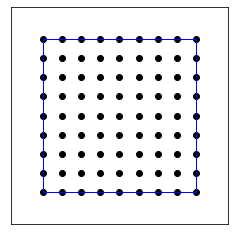

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)

grid = []
f = 15/10
for i in range(9):
    for j in range(9):
        grid.append([-6+i*f,-6+j*f])
grid = np.array(grid)
ax.scatter(grid[:,0],grid[:,1], c = 'black')
rect = plt.Rectangle((-6, -6),12,12, color='b', fill=False)
ax.add_patch(rect)
ax.axes.set_aspect('equal')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('figures/regular.png', dpi=1024, pad_inches=0,bbox_inches='tight')

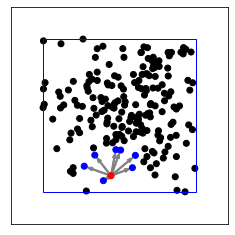

In [93]:
#Irregularity
fig = plt.figure()
ax = fig.add_subplot(111)

np.random.seed(1234)
points = np.random.normal(loc = [1,1], scale = [4,4],size=(256,2))
points = points[(points[:,1]<=6) & (points[:,1]>=-6) & (points[:,0]<=6) & (points[:,0]>=-6)]

rp = 68
bps = [64,118,186,59,94,148,149]

c = []
for i in range(points.shape[0]):
    if i==rp:
        c.append('red')
    elif i in bps:
        c.append('blue')
    else:
        c.append('black')

for bp in bps:
    ax.arrow((points[rp,0] + points[bp,0]*0.), (points[rp,1] + points[bp,1]*0.), (points[bp,0] - points[rp,0])*0.9, (points[bp,1] - points[rp,1])*0.9, width = 0.1, color = 'grey',length_includes_head = True, zorder = -1)        

ax.scatter(points[:,0],points[:,1], c = c, zorder = 1)
#Points:68 (el rojo), 59, 64, 70



rect = plt.Rectangle((-6, -6),12,12, color='blue', fill=False)
ax.add_patch(rect)
ax.axes.set_aspect('equal')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('figures/unstructured.png', dpi=1024, pad_inches=0,bbox_inches='tight')

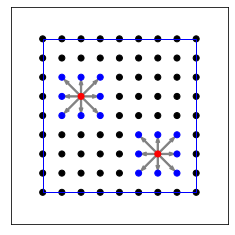

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111)

grid = []
f = 15/10
for i in range(9):
    for j in range(9):
        grid.append([-6+i*f,-6+j*f])
grid = np.array(grid)

rp = 23
bps = [24,22,15,14,13,31,32,33]

rp2 = 56
bps2 = [57,55,48,47,46,64,65,66]

c = []
for i in range(grid.shape[0]):
    if i==rp or i == rp2:
        c.append('red')
    elif i in bps or i in bps2:
        c.append('blue')
    else:
        c.append('black')

for bp in bps:
    ax.arrow(grid[rp,0], grid[rp,1], (grid[bp,0] - grid[rp,0])*0.9, (grid[bp,1] - grid[rp,1])*0.9, width = 0.1, color = 'grey',length_includes_head = True, zorder = -1)        
for bp in bps2:
    ax.arrow(grid[rp2,0], grid[rp2,1], (grid[bp,0] - grid[rp2,0])*0.9, (grid[bp,1] - grid[rp2,1])*0.9, width = 0.1, color = 'grey',length_includes_head = True, zorder = -1)   

ax.scatter(grid[:,0],grid[:,1], c = c)
rect = plt.Rectangle((-6, -6),12,12, color='b', fill=False)
ax.add_patch(rect)
ax.axes.set_aspect('equal')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('figures/structured.png', dpi=1024, pad_inches=0,bbox_inches='tight')

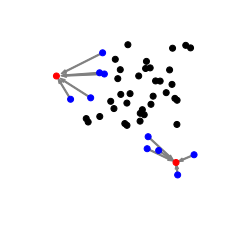

In [111]:
#Irregularity
fig = plt.figure()
ax = fig.add_subplot(111)

np.random.seed(1234)
points = np.random.normal(loc = [1,1], scale = [4,4],size=(64,2))
points = points[(points[:,1]<=6) & (points[:,1]>=-6) & (points[:,0]<=6) & (points[:,0]>=-6)]

rp = 45
rp2 = 17
bps = [1,18,21,24,44]
bps2 = [14,26,38,39,0]

c = []
for i in range(points.shape[0]):
    if i==rp or i == rp2:
        c.append('red')
    elif i in bps or i in bps2:
        c.append('blue')
    else:
        c.append('black')
        
for bp in bps:
    ax.arrow(points[bp,0], points[bp,1], (points[rp,0] - points[bp,0])*0.9, (points[rp,1] - points[bp,1])*0.9, width = 0.1, color = 'grey',length_includes_head = True, zorder = -1)        
for bp in bps2:
    ax.arrow(points[bp,0], points[bp,1], (points[rp2,0] - points[bp,0])*0.9, (points[rp2,1] - points[bp,1])*0.9, width = 0.1, color = 'grey',length_includes_head = True, zorder = -1)   


ax.scatter(points[:,0],points[:,1], c = c, zorder = 1)
#Points:68 (el rojo), 59, 64, 70

ax.axes.set_aspect('equal')
plt.xlim(-10,8.5)
plt.ylim(-10,8.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axis('off')
fig.savefig('figures/5-NN.png', dpi=1024, pad_inches=0,bbox_inches='tight')

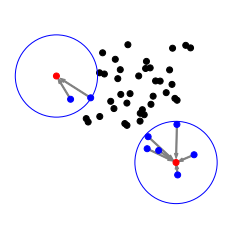

In [112]:
#Irregularity
fig = plt.figure()
ax = fig.add_subplot(111)

np.random.seed(1234)
points = np.random.normal(loc = [1,1], scale = [4,4],size=(64,2))
points = points[(points[:,1]<=6) & (points[:,1]>=-6) & (points[:,0]<=6) & (points[:,0]>=-6)]

rp = 45
rp2 = 17
bps = []
bps2 = []

rad = 3.5

for i in range(points.shape[0]):
    dist1 = np.sqrt((points[rp,0]-points[i,0])**2+(points[rp,1]-points[i,1])**2)
    dist2 = np.sqrt((points[rp2,0]-points[i,0])**2+(points[rp2,1]-points[i,1])**2)
    if i!=rp and dist1 < rad:
        bps.append(i)
    if i!=rp2 and dist2 < rad:
        bps2.append(i)

c = []
for i in range(points.shape[0]):
    if i==rp or i == rp2:
        c.append('red')
    elif i in bps or i in bps2:
        c.append('blue')
    else:
        c.append('black')
        
for bp in bps:
    ax.arrow(points[bp,0], points[bp,1], (points[rp,0] - points[bp,0])*0.9, (points[rp,1] - points[bp,1])*0.9, width = 0.1, color = 'grey',length_includes_head = True, zorder = -1)        
for bp in bps2:
    ax.arrow(points[bp,0], points[bp,1], (points[rp2,0] - points[bp,0])*0.9, (points[rp2,1] - points[bp,1])*0.9, width = 0.1, color = 'grey',length_includes_head = True, zorder = -1)   


ax.scatter(points[:,0],points[:,1], c = c, zorder = 1)

rect = plt.Circle((points[rp,0], points[rp,1]),rad, color='b', fill=False)
ax.add_patch(rect)
rect = plt.Circle((points[rp2,0], points[rp2,1]),rad, color='b', fill=False)
ax.add_patch(rect)

ax.axes.set_aspect('equal')
plt.xlim(-10,8.5)
plt.ylim(-10,8.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axis('off')
fig.savefig('figures/query_ball_point.png', dpi=1024, pad_inches=0,bbox_inches='tight')